In [5]:
import numpy as np
import sparapy as sp
from sparapy import image_source as ims


import pyfar as pf
import matplotlib.pyplot as plt
%matplotlib ipympl
from datetime import datetime

fast rad

In [6]:
# Define parameters
X = 3
Y = 3
Z = 3
patch_size = 0.5
ir_length_s = 2
sampling_rate = 1000
max_order_k = 150
speed_of_sound = 346.18
absorption = 0.1

# create geometry
walls = sp.testing.shoebox_room_stub(X, Y, Z)
source_pos = [0.5, 0.5, 0.5]
source = sp.geometry.SoundSource(source_pos, [0, 1, 0], [0, 0, 1])
receiver_pos = [0.25, 0.25, 0.25]


start = datetime.now()

# create object
radiosity_fast = sp.DRadiosityFast.from_polygon(walls, patch_size)

# create directional scattering data (totally diffuse)
sources = pf.Coordinates(0, 0, 1)
receivers = pf.Coordinates(0, 0, 1)
frequencies = np.array([500])
data_scattering = pf.FrequencyData(
    np.ones((sources.csize, receivers.csize, frequencies.size)), frequencies)

# set directional scattering data
radiosity_fast.set_wall_scattering(
    np.arange(len(walls)), data_scattering, sources, receivers)

# set air absorption
radiosity_fast.set_air_attenuation(
    pf.FrequencyData(
        np.zeros_like(data_scattering.frequencies),
        data_scattering.frequencies))

# set absorption coefficient
radiosity_fast.set_wall_absorption(
    np.arange(len(walls)),
    pf.FrequencyData(
        np.zeros_like(data_scattering.frequencies)+absorption,
        data_scattering.frequencies))

# calculate from factors including directivity and absorption
radiosity_fast.bake_geometry(algorithm='order')

# initialize source energy at each patch
radiosity_fast.init_source_energy(source_pos, algorithm='order')

# gather energy at receiver
ir_fast = radiosity_fast.calculate_energy_exchange_receiver(
    receiver_pos, speed_of_sound=speed_of_sound,
    histogram_time_resolution=1/sampling_rate, histogram_length=ir_length_s,
    algorithm='order', max_depth=max_order_k)
reverberation_fast = pf.Signal(ir_fast, sampling_rate=sampling_rate)

# stop timer
delta = (datetime.now() - start)
print(f"Time elapsed: {delta}")
fast_time_s = (delta.seconds*1e6 + delta.microseconds)/1e6

C:\Users\Anindita I. Hapsari\AppData\Local\Temp\ipykernel_11072\3220194775.py:32: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  radiosity_fast.set_wall_scattering(


Time elapsed: 0:01:00.047047


image source

In [2]:
MaxOrder = 5


RoomSizes = (3, 3, 3)
WallsHesse = ims.get_walls_hesse(*RoomSizes)


WallsR = 0.9
SourcePos = [0.50, 0.50, 0.50]




ISList_valid = ims.calculate_image_sources(WallsHesse, SourcePos, MaxOrder)


ReceiverPos = [0.25, 0.25, 0.25]
ISList_audible = ims.filter_image_sources(ISList_valid, WallsHesse, ReceiverPos)


impulse_response = ims.calculate_impulse_response(ISList_audible, WallsR, ReceiverPos)
energy = np.square(impulse_response)
image_source = pf.Signal(energy, 10000)


compare

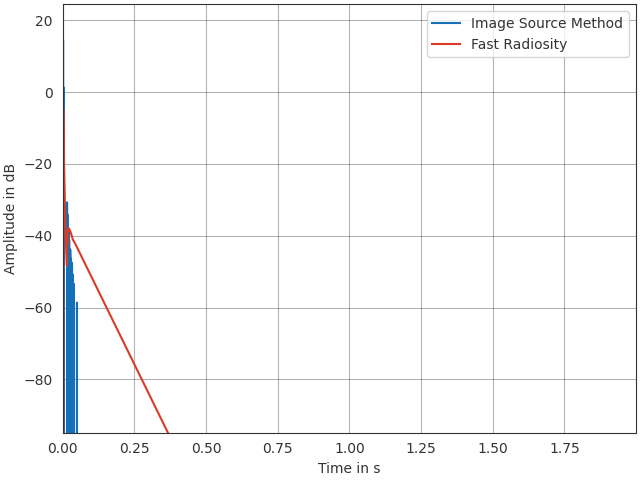

In [7]:
pf.plot.use()
plt.figure()

ax = pf.plot.time(image_source, dB=True, label="Image Source Method")
ax = pf.plot.time(reverberation_fast, dB=True, label="Fast Radiosity")

#title = title = f"Radiosity Order {k} Patch Size {patch_size} vs Image Source Order {MaxOrder}"
ax.legend(loc="upper right")
#plt.title(title)
plt.show()